# Encoding Time Series Data as Image Fields #

In this experiment, we import the GunPoint data into the Aretas platform and export as Gramian Image fields.

The GunPoint dataset information can be found here: http://www.timeseriesclassification.com/description.php?Dataset=GunPoint

This experiment, using image fields, exceeds SOTA, demonstrating up to 100% classifcation accuracy on the validation set and 99.33% accuracy on the unseen test set.  

Class 1 is "gun" and class 2 is "no gun (pointing)"

<img src="GunPoint.png" width="300px">

In [1]:
from fastai.vision.all import *
from vit_pytorch import ViT
from vit_pytorch.deepvit import DeepViT

In [2]:
image_data_path = Path("GunPoint/train")

In [3]:
image_data_path.ls()

(#3) [Path('GunPoint/train/1'),Path('GunPoint/train/2'),Path('GunPoint/train/models')]

In [4]:
files = get_image_files(image_data_path)

In [5]:
len(files)

150

In [6]:
files[0]

Path('GunPoint/train/1/102.png')

In [7]:
files[0].parts[len(files[0].parts)-2]

'1'

In [8]:
def label_func(f):
    label = f.parts[len(f.parts)-2]
    return label


In [9]:
set_seed(8008, True)
dls = ImageDataLoaders.from_path_func(
    image_data_path, 
    files, 
    label_func,
    valid_pct=0.2, 
    bs=16, 
    item_tfms=Resize((200,200), ResizeMethod.Squish)
)

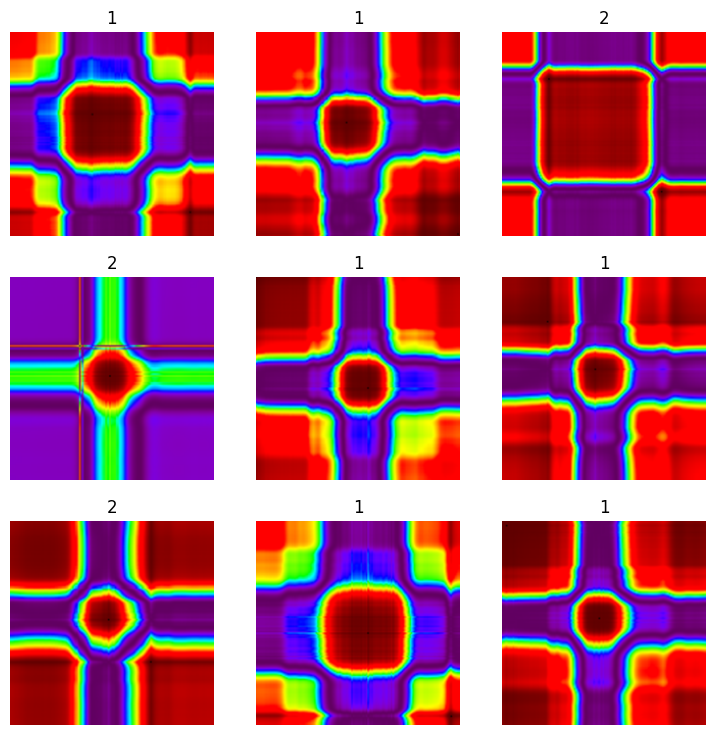

In [10]:
dls.show_batch()

SuggestedLRs(valley=6.918309736647643e-06)

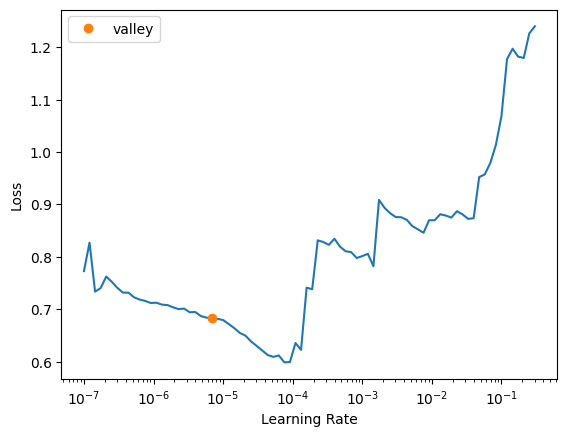

In [11]:
v = ViT(
    image_size = 200,
    patch_size = 50,
    num_classes = 2,
    dim = 1024,
    depth = 12,
    heads = 32,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

set_seed(8008, True)

learn = Learner(dls, v, metrics=accuracy)

learn.lr_find(num_it=100)

In [14]:
lr = 6.918309736647643e-06
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,0.367962,0.619937,0.700000,00:00


epoch,train_loss,valid_loss,accuracy,time
0,0.236846,0.248929,0.866667,00:00
1,0.269726,0.270239,0.900000,00:00
2,0.245981,0.056648,1.000000,00:00
3,0.212390,0.046486,1.000000,00:00


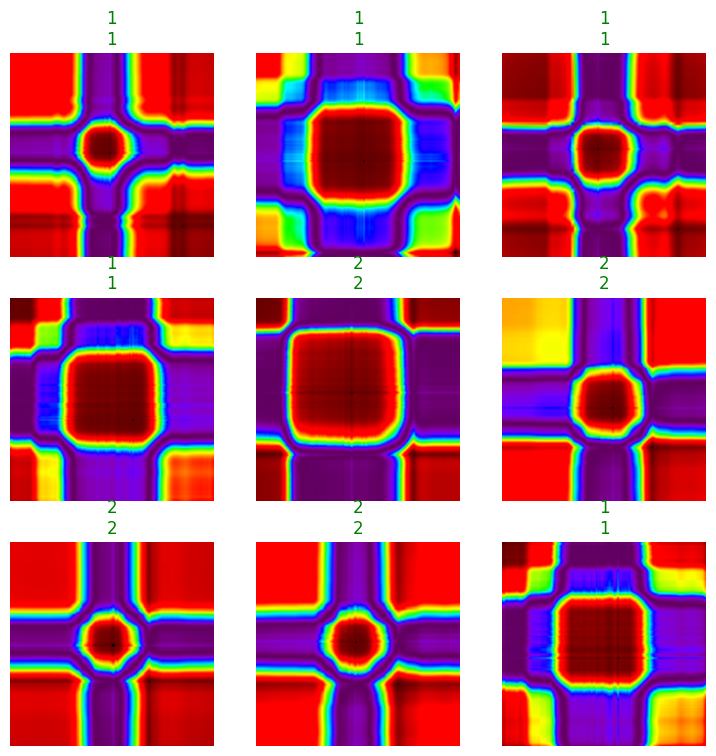

In [15]:
learn.show_results()

In [16]:
interp = Interpretation.from_learner(learn)

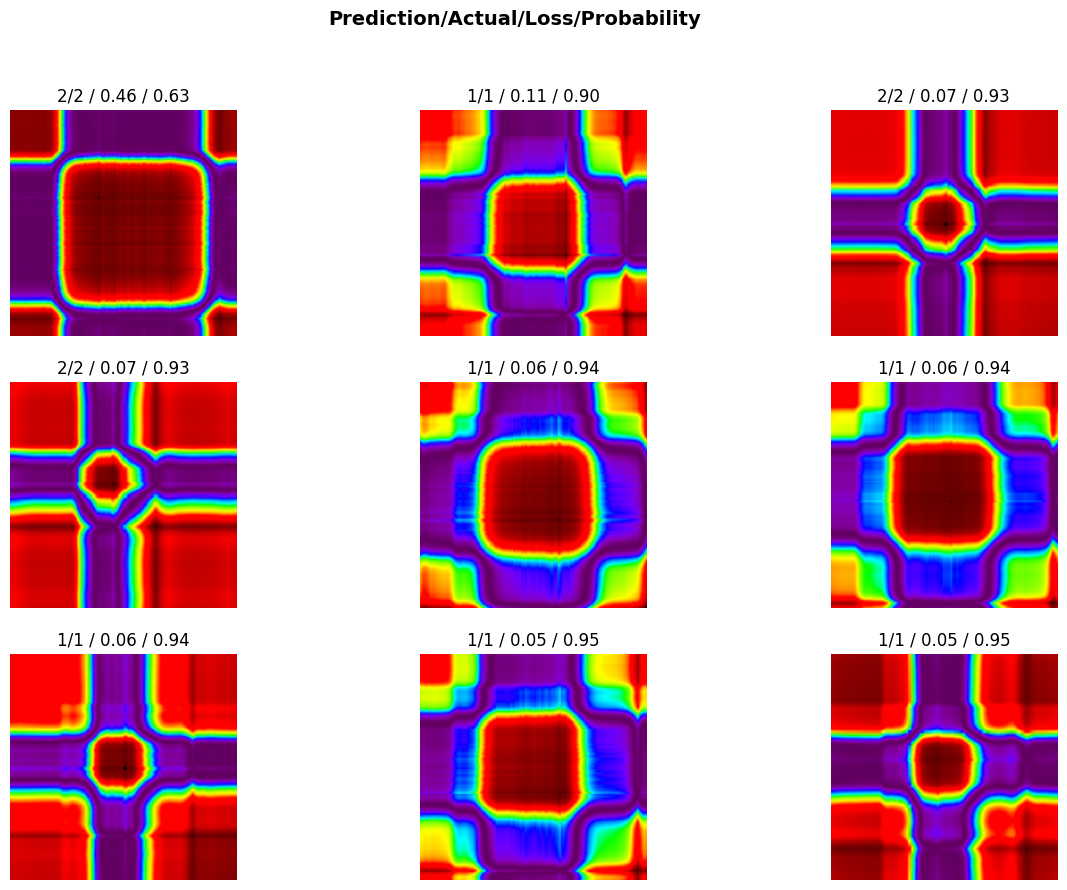

In [17]:
interp.plot_top_losses(9, figsize=(15,10))

In [18]:
test_set_path = Path("Y:/ai-time-series-classification-export-gaf/GunPoint/test")
test_set_images = get_image_files(test_set_path)
test_set_images

(#150) [Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/102.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/104.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/105.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/108.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/110.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/112.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/113.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/115.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/116.png'),Path('Y:/ai-time-series-classification-export-gaf/GunPoint/test/1/129.png')...]

In [19]:
%%capture
def get_conf_matrix(debug=False):
    
    accuracy = [[0.0,0.0],[0.0,0.0]]
    
    for i in test_set_images:
        
        result = learn.predict(i);
        actual = i.parts[len(i.parts)-2]
        prediction = result[0]
        
        if debug:
            
            print("---------------------------------")
            print("Actual:" + actual)
            print("Prediction:" + result[0])
            target_prob = result[2][0]
            print(float(target_prob))
            print(result)
            print("---------------------------------")
            print('\n')

        # true positive
        if(actual == '1' and prediction == '1'):
            accuracy[0][0] = accuracy[0][0] + 1.0

        # false negative
        if(actual == '1' and prediction != '1'):
            accuracy[1][0] = accuracy[1][0] + 1.0

        #false positive
        if(actual != '1' and prediction == '1'):
            accuracy[0][1] = accuracy[0][1] + 1.0

        #true negative
        if(actual != '1' and prediction != '1'):
            accuracy[1][1] = accuracy[1][1] + 1.0
            
    return accuracy

conf_matrix = get_conf_matrix()


Confusion matrix:

In [20]:
from IPython.display import display, HTML
display(HTML(pd.DataFrame(conf_matrix).to_html()))

,0,1
0,76.0,3.0
1,0.0,71.0


In [21]:
# accuracy
accuracy_t = Tensor(conf_matrix)
accuracy_val = accuracy_t.trace() / accuracy_t.sum()
print(accuracy_val)

tensor(0.9800)
